## Introductions

This note is refered from Shan-Hung Wu's Deep Learning course from National Tsing Hua University. Here is the lecture notebook: https://nthu-datalab.github.io/ml/labs/03_Decision-Trees_Random-Forest/03_Decision-Tree_Random-Forest.html

In [1]:
%matplotlib inline

import os
from IPython.display import display
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

/home/eli/.conda/envs/ml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Decision Tree

In [ ]:
df = pd.read_csv('http://mlr.cs.umass.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df.head()

In [39]:
X_origin = df.drop('Class label', axis=1)
Y_origin = df['Class label']

X_train, X_test, Y_train, Y_test = train_test_split(X_origin, Y_origin, test_size=0.3, random_state=0)
print("# of training examples:", X_train.shape[0])
print("# of testing examples:", X_test.shape[0])
print('Class labels:', np.unique(Y_origin))

# of training examples: 124
# of testing examples: 54
Class labels: [1 2 3]


In [85]:
%%time
dst = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dst.fit(X_train, Y_train)

CPU times: user 5.72 ms, sys: 190 µs, total: 5.91 ms
Wall time: 4.39 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [52]:
Y_pred = dst.predict(X_test)
Accuracy = (Y_pred == Y_test).sum() / Y_pred.shape[0]
print("Accuracy: %.2f" % Accuracy)

# a more convenient way to compute accuracy:
acc = accuracy_score(Y_test, Y_pred, normalize=True)
num_of_mis_samples = accuracy_score(Y_test, Y_pred, normalize=False)
print("Accuracy by sklean: %.2f" % acc)
print("# of Misclassified samples: %d" % num_of_mis_samples)

# We can assign the weights for each samples
'''
Signature: accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
- sample_weight : array-like of shape = [n_samples], optional
'''

Accuracy: 0.96
Accuracy by sklean: 0.96
# of Misclassified samples: 52


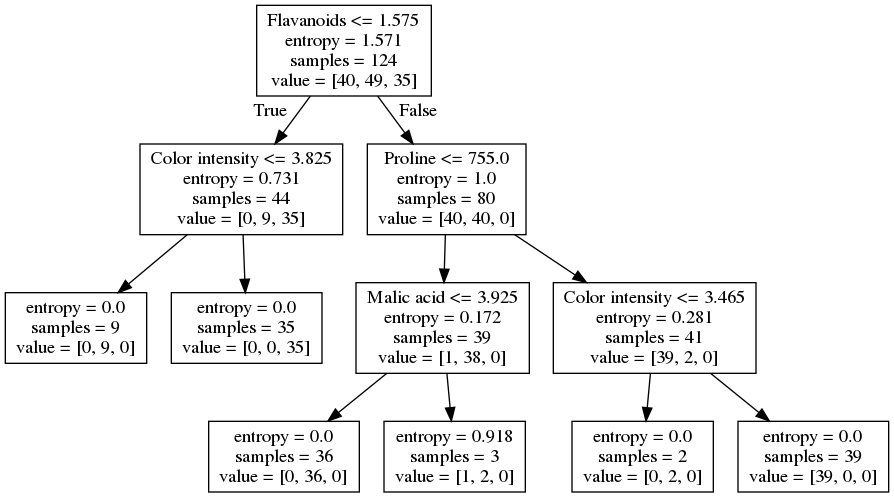

In [60]:
if not os.path.exists('./output/'):
    os.mkdir('./output')
    
export_graphviz(
    dst,
    out_file='./output/tree.dot',
    feature_names=X_origin.columns.values
)

# Before we use system command, we need to install graphviz first:
# sudo apt install graphviz
if not os.path.exists('./output/tree.png'):
    os.system('dot -Tpng ./output/tree.dot -o ./output/tree.png')
    
from PIL import Image
img = Image.open('./output/tree.png')
img

## Random Forests

In [86]:
%%time
forest = RandomForestClassifier(criterion='entropy',
                               n_estimators=10,
                               random_state=1,
                               n_jobs=2)
forest.fit(X_train, Y_train)

CPU times: user 29.2 ms, sys: 430 µs, total: 29.6 ms
Wall time: 111 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [87]:
Y_forest_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_forest_pred))

Accuracy: 0.96


## Training Execution Time
We can use magic command: `%%time` to measure the execution for specific cell block and `%time` for a line expression e.g., `%time 2**128`. Besides, if we want to measure the execution time of a statement, `%timeit` is a proper choice. For example: `%timeit -r 4 u == None`. 

more details, please take a look: [IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time)


As we can see, the training time for building a DST is about 6ms, but 201 ms for building random forest. Next we will try to increase the number of estimators to see what happen?

In [90]:
%%time

# More estimators will increase the test accuracy, but the execution
# time for training model also grows siginificantly.
forest = RandomForestClassifier(criterion='entropy',
                               n_estimators=120,
                               random_state=1,
                               n_jobs=2)
forest.fit(X_train, Y_train)

CPU times: user 178 ms, sys: 57 ms, total: 235 ms
Wall time: 259 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [91]:
Y_forest_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_forest_pred))

Accuracy: 0.98
